In [40]:
from util import *
import pandas as pd
from sklearn.preprocessing import scale
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import HTML, display, Markdown
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
df_ppg = pd.read_csv('data/PPG_FOG_NEUROCOM_FINAL_v2.csv', index_col=0)
df_sda = pd.read_csv('data/PPG_SDA_contrast.csv', index_col=0)
df_group = df_ppg[[]].join(df_sda[['Group']])
df_group.Group.value_counts()

Non-freezers    59
Freezers        16
Name: Group, dtype: int64

In [3]:
df_cop = pd.read_csv('data/all_cop_measures.csv', index_col=0).loc[df_ppg.index]
critdisp_sot4 = df_cop.query('vision == "OPEN" and prop == "SWAY" and has_fog in [0, 1]').critical_displacement_Diffusion_AP
critdisp_sot1 = df_cop.query('vision == "OPEN" and prop == "FIXED" and has_fog in [0, 1]').critical_displacement_Diffusion_AP
critdisp_delta = critdisp_sot4 - critdisp_sot1
min_critdisp_delta = critdisp_delta.min()
pd.Series(critdisp_delta).describe()

count    75.000000
mean      1.516833
std       2.841651
min      -1.281173
25%       0.028141
50%       0.468460
75%       1.592317
max      17.048833
Name: critical_displacement_Diffusion_AP, dtype: float64

In [4]:
df_k3 = pd.read_csv('data/PPG_NEUROCOM_PMPk3_rh_ctx.csv', index_col=0)
df_k3.describe().T

,count,mean,std,min,25%,50%,75%,max
right_cortex,75.0,0.025988,0.004066,0.013639,0.023608,0.026368,0.028245,0.03586


In [5]:
df_group.join(df_k3).groupby('Group').describe().T

Group                Freezers  Non-freezers
right_cortex count  16.000000     59.000000
             mean    0.027517      0.025573
             std     0.004082      0.003995
             min     0.018025      0.013639
             25%     0.024988      0.023419
             50%     0.027338      0.025653
             75%     0.030409      0.027755
             max     0.034472      0.035860

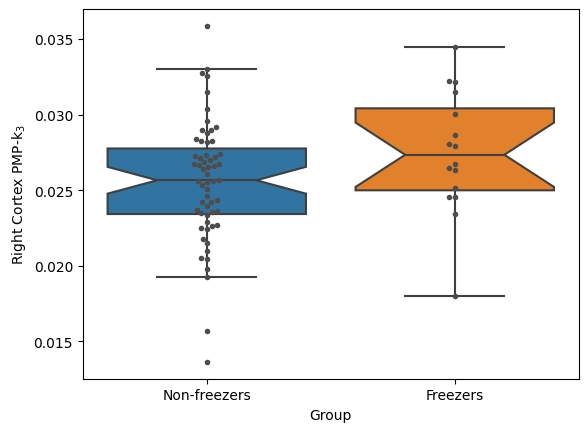

MannwhitneyuResult(statistic=345.0, pvalue=0.1018356013666506)

In [6]:
df_roi_comp = df_group.join(df_k3).join(df_ppg[['clinical_fall_history']])

sns.boxplot(
    df_roi_comp,
    x='Group',
    y='right_cortex',
    notch=True,
    fliersize=0
)
sns.swarmplot(
    df_roi_comp,
    x='Group',
    y='right_cortex',
    color='gray',
    linewidth=2,
    s=2
)
plt.ylabel('Right Cortex PMP-k$_3$')
plt.show()

stats.mannwhitneyu(
    df_roi_comp.groupby('Group').get_group('Non-freezers').right_cortex,
    df_roi_comp.groupby('Group').get_group('Freezers').right_cortex
)

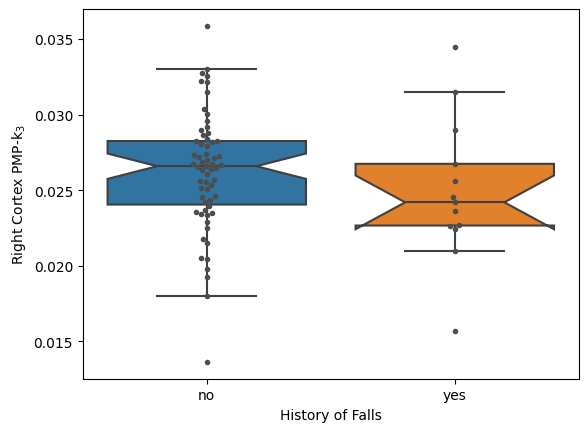

MannwhitneyuResult(statistic=499.0, pvalue=0.1813349250272266)

In [7]:
sns.boxplot(
    df_roi_comp,
    x='clinical_fall_history',
    y='right_cortex',
    notch=True,
    fliersize=0
)
sns.swarmplot(
    df_roi_comp,
    x='clinical_fall_history',
    y='right_cortex',
    color='gray',
    linewidth=2,
    s=2
)
plt.ylabel('Right Cortex PMP-k$_3$')
plt.xlabel('History of Falls')
plt.show()
stats.mannwhitneyu(
    df_roi_comp.groupby('clinical_fall_history').get_group('no').right_cortex,
    df_roi_comp.groupby('clinical_fall_history').get_group('yes').right_cortex
)

In [8]:
numvars = ['led_calculation', 'updrs_iii', 'educ_year', 'striatal_dtbz', 'moca', 'weight', 'height', 'biothes', 'age', 'duration', 'tmt_ba']
catvars = ['Group', 'clinical_balance_impaired', 'ACB_cutoff', 'clinical_fall_history']
df_reg_sot4 = df_group.join(df_ppg.join(df_k3))
df_reg_sot4[numvars] = scale(df_reg_sot4[numvars])
df_reg_sot4['right_cortex'] = scale(df_reg_sot4['right_cortex'])
# we have to subtract minimum value and add 1 so that values are all positive and above 1 for modelliing
df_reg_sot4 = df_reg_sot4.assign(critdisp = (critdisp_delta - min_critdisp_delta) + 1)
df_reg_sot4.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,75.0,-7.401487e-18,1.006734,-1.205373,-0.602687,-0.361612,0.602687,3.495583
moca,75.0,4.796163e-16,1.006734,-4.223747,-0.677691,0.110322,0.504328,1.686347
educ_year,75.0,1.236048e-16,1.006734,-2.138176,-1.052195,0.033786,0.757774,1.481761
age,75.0,6.761258e-16,1.006734,-2.177428,-0.592655,-0.064397,0.841188,1.897703
updrs_iii,75.0,1.258253e-16,1.006734,-1.845790,-0.723236,-0.193729,0.695842,3.068033
led_calculation,75.0,-1.110223e-16,1.006734,-1.274474,-0.666091,-0.057708,0.347880,5.174381
weight,75.0,-7.993606e-17,1.006734,-1.691654,-0.670353,-0.166166,0.557794,3.324357
height,75.0,-1.548206e-15,1.006734,-2.561758,-0.655968,-0.020705,0.614558,2.379178
striatal_dtbz,75.0,-6.870430e-16,1.006734,-1.840707,-0.739854,-0.082179,0.518795,2.560662
has_fog,75.0,2.133333e-01,0.412420,0.000000,0.000000,0.000000,0.000000,1.000000


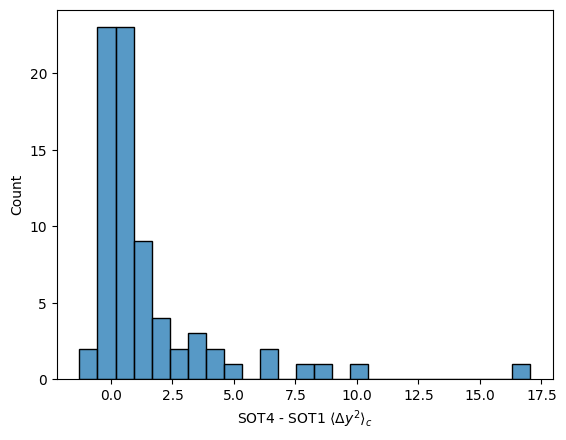

In [9]:
# for plotting I have to transform back to original units
sns.histplot((df_reg_sot4.critdisp - 1) + min_critdisp_delta)
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

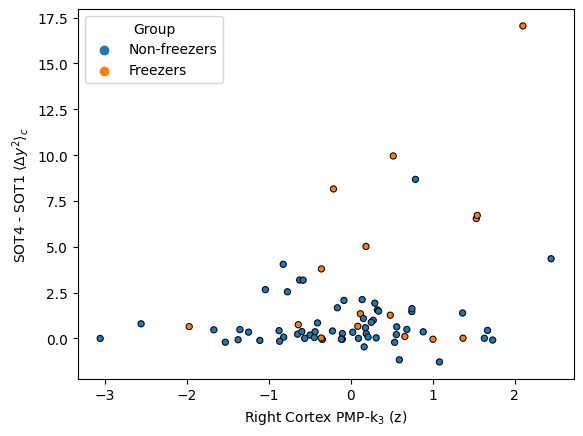

In [10]:
sns.scatterplot(
    data=df_reg_sot4.assign(critdisp = (df_reg_sot4.critdisp - 1) + min_critdisp_delta),
    x='right_cortex',
    y='critdisp',
    hue='Group',
    s=20,
    edgecolor='black',
    linewidth=0.75
)

plt.ylabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.xlabel('Right Cortex PMP-k$_3$ (z)')
plt.show()

In [11]:
model_null = smf.glm(
    'critdisp ~ 1',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

model_ctx = smf.glm(
    'critdisp ~ right_cortex',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## Right Cortex PMP-k$_3$ Model'),
    HTML(model_ctx.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_null, model_ctx))
)

## Right Cortex PMP-k$_3$ Model

$\chi^2$: 20.213728, P: 0.000007

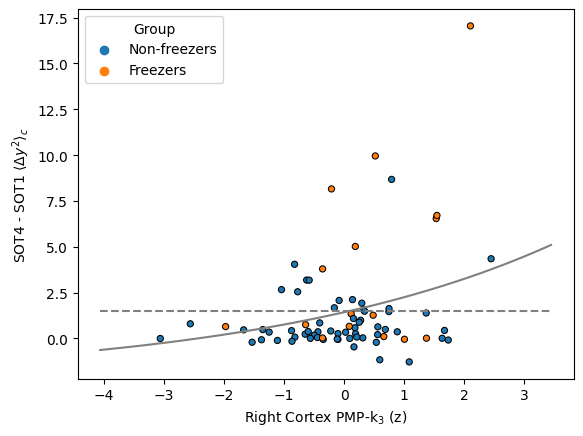

In [12]:
rh_min, rh_max = df_reg_sot4.right_cortex.min(), df_reg_sot4.right_cortex.max()
rh_range = np.arange(rh_min -1, rh_max+1, 0.1)

predictions_ctx = model_ctx.predict(pd.DataFrame({'right_cortex': rh_range}))
predictions_null = model_null.predict(pd.DataFrame({'right_cortex': rh_range}))

sns.scatterplot(
    data=df_reg_sot4.assign(critdisp = (df_reg_sot4.critdisp - 1) + min_critdisp_delta) ,
    x='right_cortex',
    y='critdisp',
    hue='Group',
    s=20,
    edgecolor='black',
    linewidth=0.75
)

# model predictions also have to be transformed back
plt.plot(rh_range, (predictions_ctx - 1) + min_critdisp_delta, color='gray')
plt.plot(rh_range, (predictions_null - 1) + min_critdisp_delta, color='gray', linestyle='dashed')
plt.ylabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.xlabel('Right Cortex PMP-k$_3$ (z)')
plt.show()

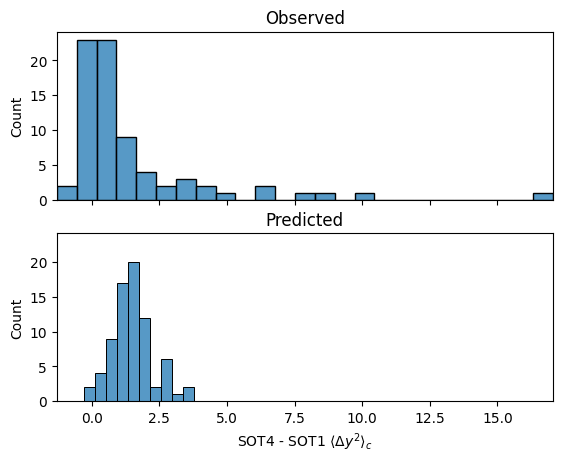

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_ctx.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [14]:
model_fog = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers"))',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## FOG Independent Effect Model'),
    HTML(model_fog.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_ctx, model_fog))
)

## FOG Independent Effect Model

$\chi^2$: 19.768616, P: 0.000009

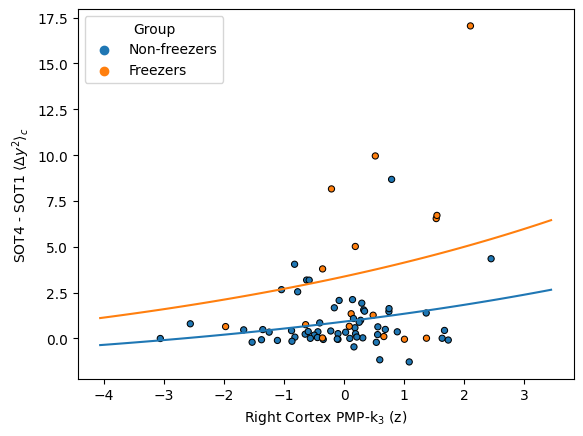

In [15]:
predictions_fog = model_fog.predict(pd.DataFrame({'right_cortex': rh_range, 'Group': 'Freezers'}))
predictions_nofog = model_fog.predict(pd.DataFrame({'right_cortex': rh_range, 'Group': 'Non-freezers'}))

sns.scatterplot(
    data=df_reg_sot4.assign(critdisp = (df_reg_sot4.critdisp - 1) + min_critdisp_delta) ,
    x='right_cortex',
    y='critdisp',
    hue='Group',
    s=20,
    edgecolor='black',
    linewidth=0.75
)

plt.plot(rh_range, (predictions_nofog - 1) + min_critdisp_delta)
plt.plot(rh_range, (predictions_fog - 1) + min_critdisp_delta)
plt.ylabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.xlabel('Right Cortex PMP-k$_3$ (z)')
plt.show()

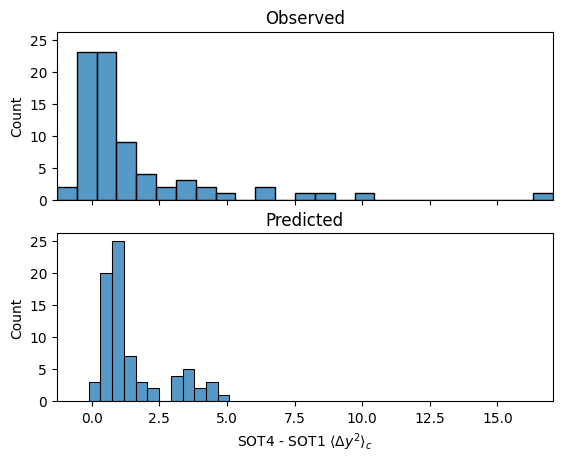

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_fog.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [17]:
model_fog_inter = smf.glm(
    'critdisp ~ right_cortex * C(Group, Treatment(reference="Non-freezers"))',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## FOG Interaction Effect Model'),
    HTML(model_fog_inter.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_fog, model_fog_inter))
)

## FOG Interaction Effect Model

$\chi^2$: 4.426378, P: 0.035388

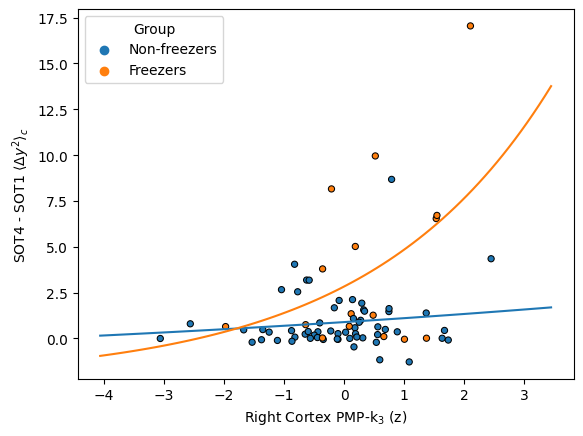

In [18]:
predictions_fog_inter = model_fog_inter.predict(pd.DataFrame({'right_cortex': rh_range, 'Group': 'Freezers'}))
predictions_nofog_inter = model_fog_inter.predict(pd.DataFrame({'right_cortex': rh_range, 'Group': 'Non-freezers'}))

sns.scatterplot(
    data=df_reg_sot4.assign(critdisp = (df_reg_sot4.critdisp - 1) + min_critdisp_delta) ,
    x='right_cortex',
    y='critdisp',
    hue='Group',
    s=20,
    edgecolor='black',
    linewidth=0.75
)

plt.plot(rh_range, (predictions_nofog_inter - 1) + min_critdisp_delta)
plt.plot(rh_range, (predictions_fog_inter - 1) + min_critdisp_delta)
plt.ylabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.xlabel('Right Cortex PMP-k$_3$ (z)')
plt.show()

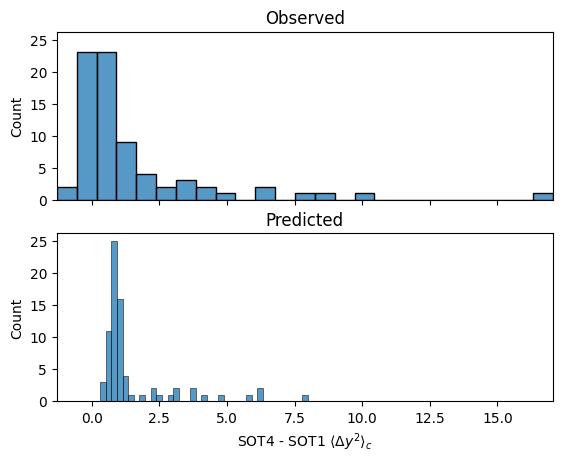

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_fog_inter.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [20]:
model_updrs = smf.glm(
    'critdisp ~ right_cortex * C(Group, Treatment(reference="Non-freezers")) + updrs_iii',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## UPDRS Model'),
    HTML(model_updrs.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_fog_inter, model_updrs))
)

## UPDRS Model

$\chi^2$: 7.284964, P: 0.006953

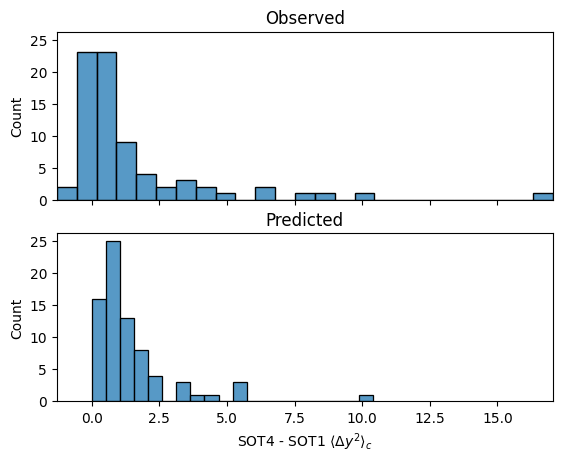

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_updrs.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [22]:
model_updrs_nointer = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## UPDRS Reduced Model'),
    HTML(model_updrs_nointer.summary().as_html()),
    Markdown('Comparison between reduced and FOG by PMP interaction model:'),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_updrs)),
    Markdown('Interaction between FOG and PMP in yielding postural control changes was driven by motor severity.'),
    Markdown('Reduced model retained.')
)

## UPDRS Reduced Model

Comparison between reduced and FOG by PMP interaction model:

$\chi^2$: 1.454561, P: 0.227797

Interaction between FOG and PMP in yielding postural control changes was driven by motor severity.

Reduced model retained.

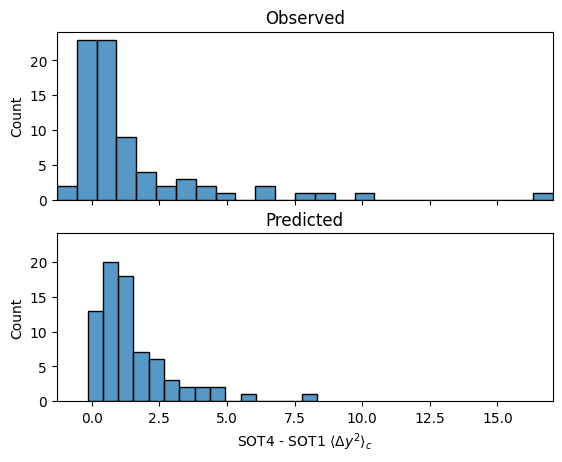

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_updrs_nointer.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [24]:
model_led = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + led_calculation',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## LED Model'),
    HTML(model_led.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_led))
)

## LED Model

$\chi^2$: 0.152757, P: 0.695915

In [25]:
model_educ = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + educ_year',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## Education Years Model'),
    HTML(model_educ.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_educ))
)

## Education Years Model

$\chi^2$: -0.189266, P: 1.000000

In [26]:
model_clinbalance = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + C(clinical_balance_impaired, Treatment(reference="N"))',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## Clinical Imbalance Model'),
    HTML(model_clinbalance.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_clinbalance))
)

## Clinical Imbalance Model

$\chi^2$: -0.234811, P: 1.000000

In [27]:
model_moca = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + moca',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## MoCA Model'),
    HTML(model_moca.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_moca))
)

## MoCA Model

$\chi^2$: -0.307476, P: 1.000000

In [28]:
model_exec = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + tmt_ba',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## TMT B-A Model'),
    HTML(model_exec.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_exec))
)

## TMT B-A Model

$\chi^2$: 0.411981, P: 0.520966

In [29]:
model_dtbz = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + striatal_dtbz',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## DTBZ Model'),
    HTML(model_dtbz.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_dtbz))
)

## DTBZ Model

$\chi^2$: -0.240003, P: 1.000000

In [30]:
model_age = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + age',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## Age Model'),
    HTML(model_age.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_updrs_nointer, model_age))
)

## Age Model

$\chi^2$: 4.315328, P: 0.037770

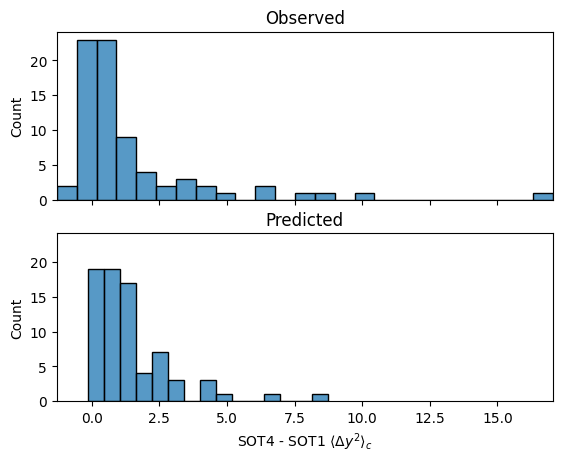

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_age.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [32]:
model_acb = smf.glm(
    'critdisp ~ right_cortex + C(Group, Treatment(reference="Non-freezers")) + updrs_iii + age + C(ACB_cutoff, Treatment(reference="Low"))',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## ACB Model'),
    HTML(model_acb.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_age, model_acb))
)

## ACB Model

$\chi^2$: 4.389890, P: 0.036153

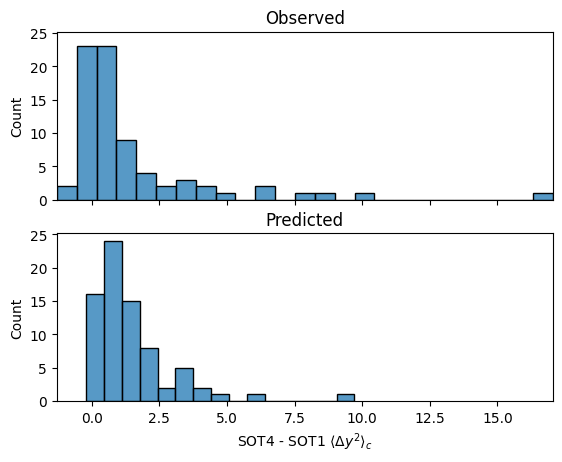

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_acb.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [34]:
model_acb_inter = smf.glm(
    'critdisp ~ C(Group, Treatment(reference="Non-freezers")) + right_cortex * C(ACB_cutoff, Treatment(reference="Low")) + updrs_iii + age',
    df_reg_sot4,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

display(
    Markdown('## ACB Interaction Model'),
    HTML(model_acb_inter.summary().as_html()),
    Markdown('$\chi^2$: %f, P: %f' % lr_test(model_acb, model_acb_inter))
)

## ACB Interaction Model

$\chi^2$: 6.987536, P: 0.008208

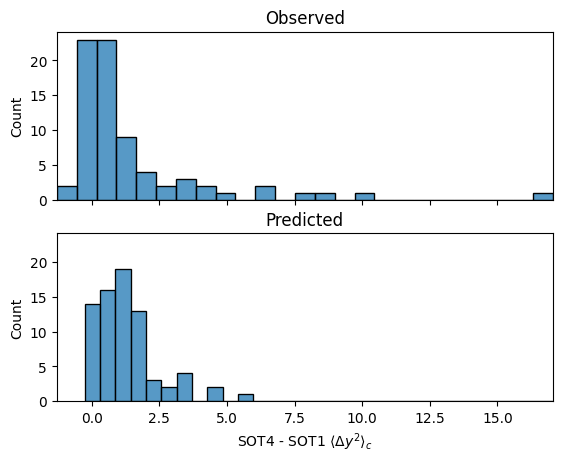

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
critdisp_obs = (df_reg_sot4.critdisp - 1) + min_critdisp_delta
ax1.set_title('Observed')
ax2.set_title('Predicted')
sns.histplot(critdisp_obs, ax=ax1)
sns.histplot((model_acb_inter.predict(df_reg_sot4) - 1) + min_critdisp_delta, ax=ax2)
plt.xlim(critdisp_obs.min(), critdisp_obs.max())
plt.xlabel(r'SOT4 - SOT1 ${\langle \Delta y^2 \rangle}_c$')
plt.show()

In [36]:

vif_dict = {}

for idx in range(model_acb_inter.model.exog.shape[1]):
    vif_dict[model_acb_inter.model.exog_names[idx]] = variance_inflation_factor(model_acb_inter.model.exog, idx)
    
pd.DataFrame({'VIF': pd.Series(vif_dict)})

,VIF
Intercept,1.684522
"C(Group, Treatment(reference=""Non-freezers""))[T.Freezers]",1.263631
"C(ACB_cutoff, Treatment(reference=""Low""))[T.High]",1.028510
right_cortex,1.207084
"right_cortex:C(ACB_cutoff, Treatment(reference=""Low""))[T.High]",1.259319
updrs_iii,1.131677
age,1.032111


ShapiroResult(statistic=0.9878870844841003, pvalue=0.6978969573974609)

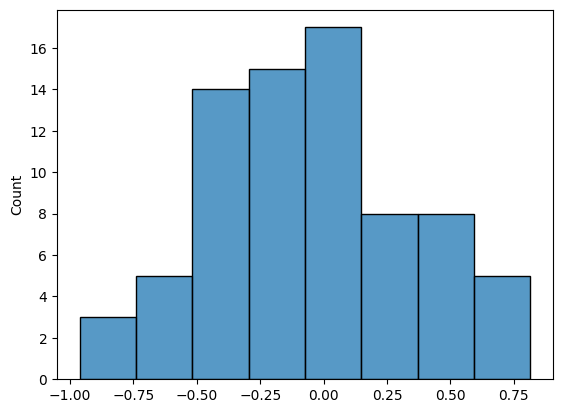

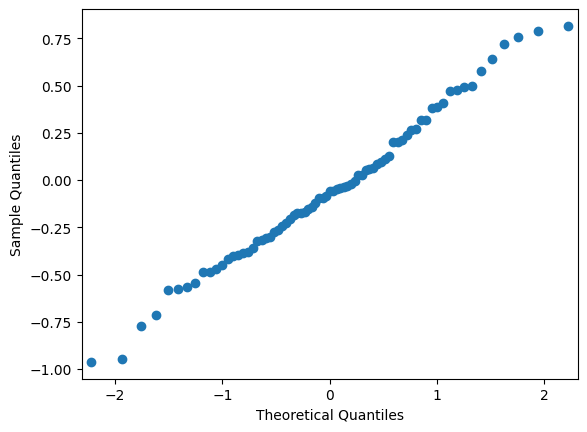

In [37]:
sns.histplot(model_acb_inter.resid_deviance)
_ = sm.qqplot(model_acb_inter.resid_deviance)
stats.shapiro(model_acb_inter.resid_deviance)

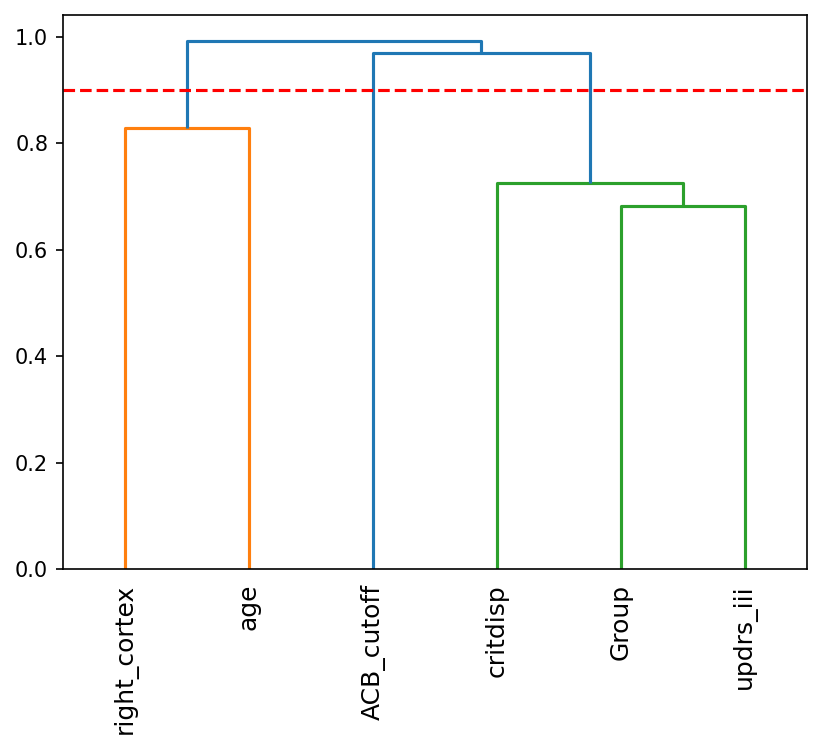

<Figure size 1920x1440 with 0 Axes>

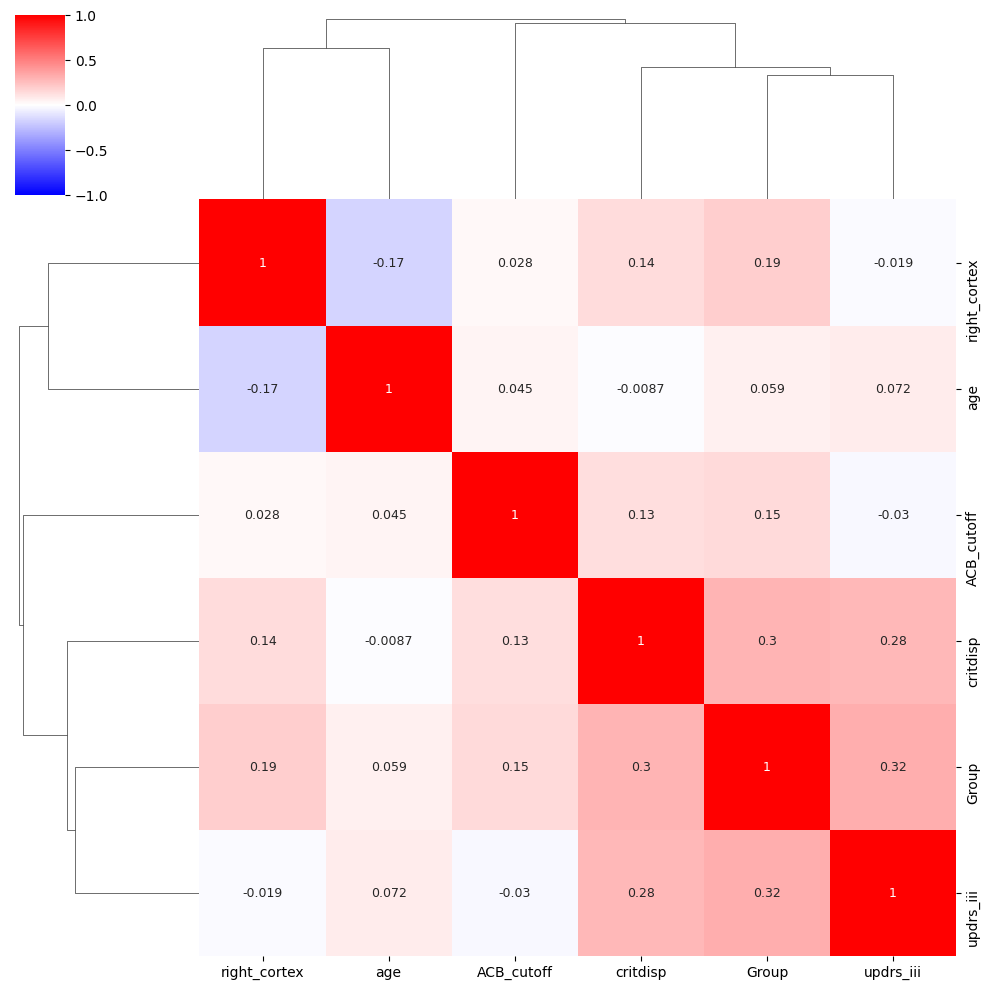

In [38]:
df_corr_format = df_reg_sot4[['Group', 'ACB_cutoff', 'right_cortex', 'updrs_iii', 'age', 'critdisp']].replace({
    'Non-freezers': 0,
    'Freezers': 1,
    'Low': 0,
    'High': 1
})

df_corr = pairwise_corr(df_corr_format, 'spearman')

Z, clusterings = hierarchical_clustering(df_corr, 0.9)

visualize_clustering(df_corr, Z)